# Imports needed for DQN

In [1]:
"""
Import Statements: From PyTorch RL Tutorial
Unchanged code from Milestone
"""
import gym
import math
import random
import numpy as np
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nle
from collections import namedtuple, deque

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Internal Imports & Setup

In [2]:
from utils.terminal_stream import TerminalStream
from utils.nle_metrics import NetHackMetricsEnv

# Experiance Class
## Used to store a state into a queue (As Memory)

In [3]:
StateTransition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [4]:
"""
This model stores replays of memories as a whole. It also holds the full set, and manages removing old memories.
From PyTorch DQN Tutorial
"""
class ReplayMemory():
    def __init__(self, max_memory):
        self.memory = deque([], maxlen=max_memory)
    
    def push(self, *newExp):
        self.memory.append(StateTransition(*newExp))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# DQN Model, with two Conv2d layers
## Takes the input provided by the dictionary in state

In [5]:
"""
DQN implementation, with convolutional layers, max pooling implemented.
"""
class DQNetwork(nn.Module):
    def __init__(self):
        super(DQNetwork, self).__init__()
        self.joe = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, padding='same'),
            nn.ReLU(), # 21 * 79 * 16
            nn.MaxPool2d(3, padding=(0,1)), # 7 * 27 * 16
            nn.Conv2d(16, 64, kernel_size=3, padding='same'),# 7 * 27 * 64
            nn.ReLU(),
            nn.MaxPool2d(3, padding=(1,0)), # 3 * 9 * 64
            nn.Flatten(),
            nn.Linear(3*9*64, 3*64),
            nn.ReLU(),
            # Hard coded activation layer
            nn.Linear(3*64, 23),
        )
        
    def forward(self, x):
        logits = self.joe(x.float())
        return logits

# Train

In [12]:
env = NetHackMetricsEnv('Testing-DQN-Metrics-4')

In [13]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
steps_done = 0
episode_durations = []
n_actions = env.action_space_size

In [14]:
policy_net = DQNetwork().to(device)
target_net = DQNetwork().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [15]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [16]:
def optimize_model(iter_num):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = StateTransition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
#     if iter_num % 1000 == 0:
#         print('Iteration number ' + str(iter_num) + ' loss: ' + str(loss.item()))
#         env.render()
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Run the algorithm for a set number of episodes

In [17]:
def concat_state(state):
    state = np.stack((state['glyphs'], state['chars'], state['colors'], state['specials']))
    state = torch.tensor(np.expand_dims(state, axis=0), device=device)
    return state

# EPISODES
num_episodes = 4000
for i_episode in range(num_episodes):
    print('Episode Number: ' + str(i_episode))
    # Initialize the environment and state
    obs = env.start(f'firstDQNrun-v{i_episode}')
    state = concat_state(obs)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        obs, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Keep track of current state and previous states 
        last_state = state
        state = concat_state(obs)

        # Store the transition in memory
        memory.push(last_state, action, state, reward)

        # Perform one step of the optimization (on the policy network)
        optimize_model(t)
        if done:
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    env.finish()
print('Complete')
# no env close
env.write_report()

Episode Number: 0
Episode Number: 1
Episode Number: 2
Episode Number: 3
Episode Number: 4
Episode Number: 5
Episode Number: 6
Episode Number: 7
Episode Number: 8
Episode Number: 9
Episode Number: 10
Episode Number: 11
Episode Number: 12
Episode Number: 13
Episode Number: 14
Episode Number: 15
Episode Number: 16
Episode Number: 17
Episode Number: 18
Episode Number: 19
Episode Number: 20
Episode Number: 21
Episode Number: 22
Episode Number: 23
Episode Number: 24
Episode Number: 25
Episode Number: 26
Episode Number: 27
Episode Number: 28
Episode Number: 29


/home/eduardo/anaconda3/envs/snowbunnies/lib/python3.9/site-packages/nle/env/base.py:496: UserWarning: Not in moveloop after 1000 tries, aborting (ttyrec: None).
  warnings.warn(


Episode Number: 30
Episode Number: 31
Episode Number: 32
Episode Number: 33
Episode Number: 34
Episode Number: 35
Episode Number: 36
Episode Number: 37
Episode Number: 38
Episode Number: 39
Episode Number: 40
Episode Number: 41
Episode Number: 42
Episode Number: 43
Episode Number: 44
Episode Number: 45
Episode Number: 46
Episode Number: 47
Episode Number: 48
Episode Number: 49
Episode Number: 50
Episode Number: 51
Episode Number: 52
Episode Number: 53
Episode Number: 54
Episode Number: 55
Episode Number: 56
Episode Number: 57
Episode Number: 58
Episode Number: 59
Episode Number: 60
Episode Number: 61
Episode Number: 62
Episode Number: 63
Episode Number: 64
Episode Number: 65
Episode Number: 66
Episode Number: 67
Episode Number: 68
Episode Number: 69
Episode Number: 70
Episode Number: 71
Episode Number: 72
Episode Number: 73
Episode Number: 74
Episode Number: 75
Episode Number: 76
Episode Number: 77
Episode Number: 78
Episode Number: 79
Episode Number: 80
Episode Number: 81
Episode Numb

KeyboardInterrupt: 

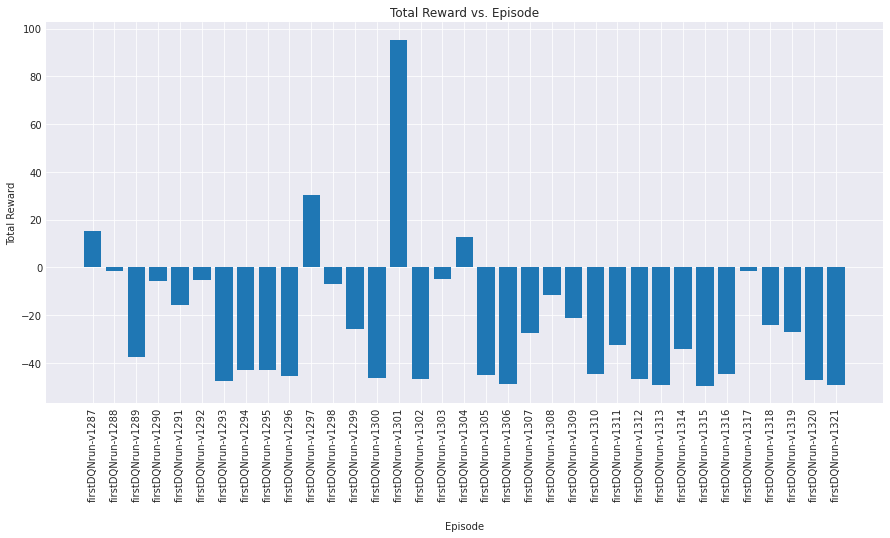

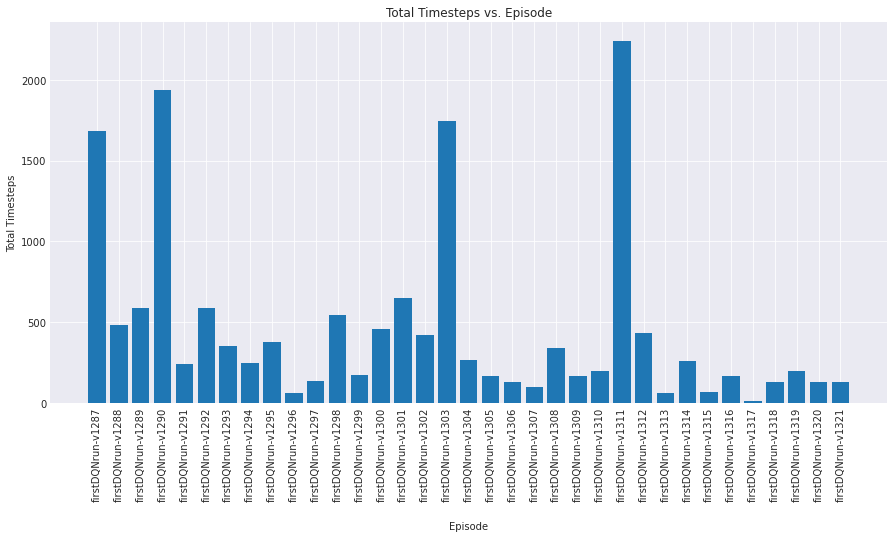

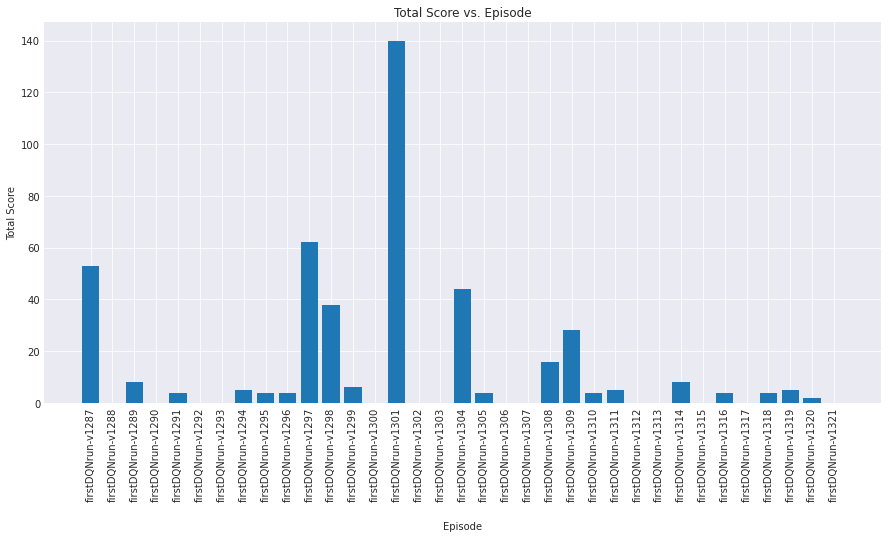

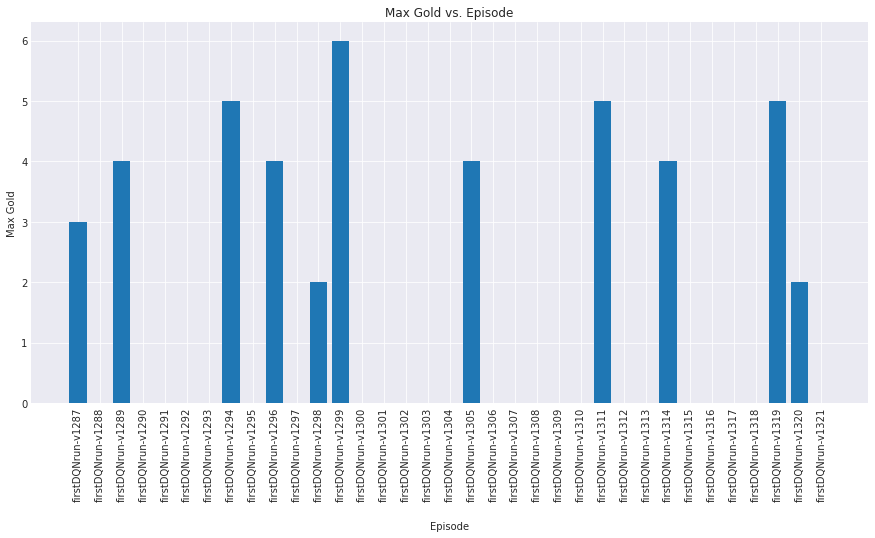

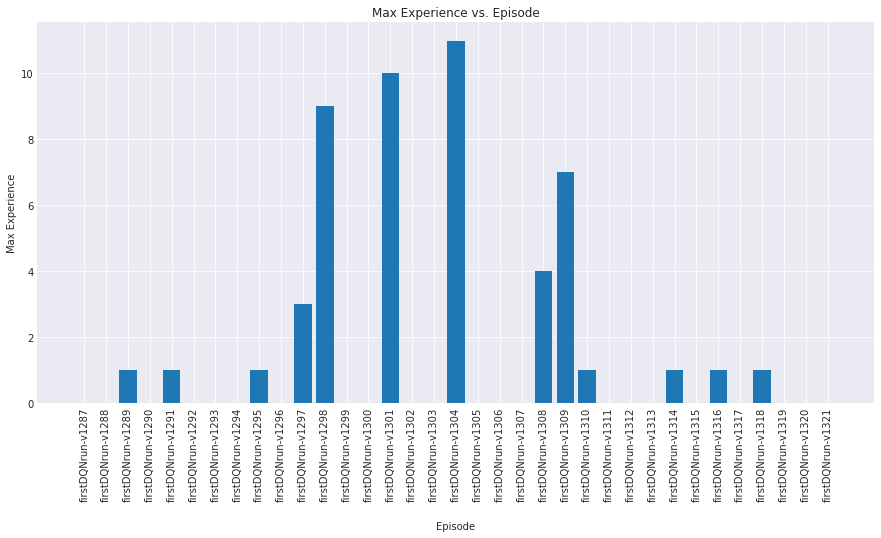

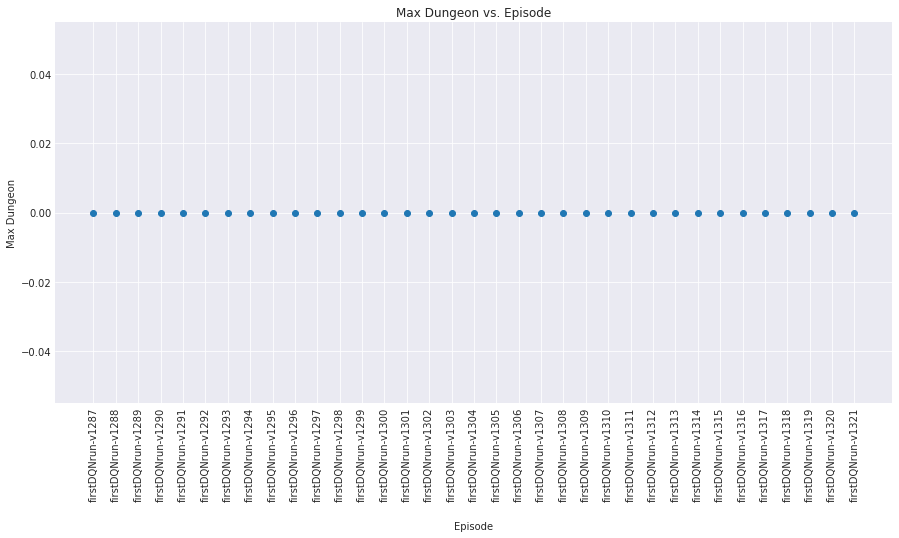

In [18]:
env.write_report()